In [53]:

import matplotlib.pyplot as plt
import pandas as pd
from torch_geometric.utils import from_smiles, to_networkx

import numpy as np
import networkx as nx
from typing import List, Optional
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
import random
import numpy as np
import networkx as nx
import warnings
from typing import List
from tqdm.auto import trange
import re
import hashlib

"""General Estimator base class."""


class Estimator(object):
    """Estimator base class with constructor and public methods."""

    seed: int

    def __init__(self):
        """Creating an estimator."""
        pass

    def fit(self):
        """Fitting a model."""
        pass

    def get_embedding(self):
        """Getting the embeddings (graph or node level)."""
        pass

    def get_memberships(self):
        """Getting the membership dictionary."""
        pass

    def get_cluster_centers(self):
        """Getting the cluster centers."""
        pass
    
    def get_params(self):
        """Get parameter dictionary for this estimator.."""
        rx = re.compile(r'^\_')
        params = self.__dict__
        params = {key: params[key] for key in params if not rx.search(key)}
        return params

    def _set_seed(self):
        """Creating the initial random seed."""
        random.seed(self.seed)
        np.random.seed(self.seed)

    @staticmethod
    def _ensure_walk_traversal_conditions(graph: nx.classes.graph.Graph) -> nx.classes.graph.Graph:
        """Ensure walk traversal conditions."""
        for node_index in trange(
            graph.number_of_nodes(),
            # We do not leave the bar.
            leave=False,
            # We only show this bar when we can expect
            # for this process to take a bit of time.
            disable=graph.number_of_nodes() < 10_000,
            desc="Checking main diagonal existance",
            dynamic_ncols=True
        ):
            if not graph.has_edge(node_index, node_index):
                warnings.warn(
                    (
                        "Please do be advised that "
                        "the graph you have provided does not "
                        "contain (some) edges in the main "
                        "diagonal, for instance the self-loop "
                        "constitued of ({}, {}). These selfloops "
                        "are necessary to ensure that the graph "
                        "is traversable, and for this reason we "
                        "create a copy of the graph and add therein "
                        "the missing edges. Since we are creating "
                        "a copy, this will immediately duplicate "
                        "the memory requirements. To avoid this double "
                        "allocation, you can provide the graph with the selfloops."
                    ).format(
                        node_index,
                        node_index
                    )
                )
                # We create a copy of the graph
                graph = graph.copy()
                # And we add the missing edges
                # for filling the main diagonal
                graph.add_edges_from((
                    (index, index)
                    for index in range(graph.number_of_nodes())
                    if not graph.has_edge(index, index)
                ))
                break

        return graph

    @staticmethod
    def _check_indexing(graph: nx.classes.graph.Graph):
        """Checking the consecutive numeric indexing."""
        numeric_indices = [index for index in range(graph.number_of_nodes())]
        node_indices = sorted([node for node in graph.nodes()])

        assert numeric_indices == node_indices, "The node indexing is wrong."

    def _check_graph(self, graph: nx.classes.graph.Graph) -> nx.classes.graph.Graph:
        """Check the Karate Club assumptions about the graph."""
        self._check_indexing(graph)
        graph = self._ensure_walk_traversal_conditions(graph)

        return graph

    def _check_graphs(self, graphs: List[nx.classes.graph.Graph]):
        """Check the Karate Club assumptions for a list of graphs."""
        graphs = [self._check_graph(graph) for graph in graphs]

        return graphs
    
class WeisfeilerLehmanHashing(object):
    """
    Weisfeiler-Lehman feature extractor class.

    Args:
        graph (NetworkX graph): NetworkX graph for which we do WL hashing.
        wl_iterations (int): Number of WL iterations.
        use_node_attribute (Optional[str]): Optional attribute name to be used.
        erase_base_feature (bool): Deleting the base features.
    """

    def __init__(
        self,
        graph: nx.classes.graph.Graph,
        wl_iterations: int,
        use_node_attribute: Optional[str],
        erase_base_features: bool,
    ):
        """
        Initialization method which also executes feature extraction.
        """
        self.wl_iterations = wl_iterations
        self.graph = graph
        self.use_node_attribute = use_node_attribute
        self.erase_base_features = erase_base_features
        self._set_features()
        self._do_recursions()

    def _set_features(self):
        """
        Creating the features.
        """
        if self.use_node_attribute is not None:
            # We retrieve the features of the nodes with the attribute name
            # `feature` and assign them into a dictionary with structure:
            # {node_a_name: feature_of_node_a}
            # Nodes without this feature will not appear in the dictionary.
            features = nx.get_node_attributes(self.graph, self.use_node_attribute)

            # We check whether all nodes have the requested feature
            if len(features) != self.graph.number_of_nodes():
                missing_nodes = []
                # We find up to five missing nodes so to make
                # a more informative error message.
                for node in tqdm(
                    self.graph.nodes,
                    total=self.graph.number_of_nodes(),
                    leave=False,
                    dynamic_ncols=True,
                    desc="Searching for missing nodes"
                ):
                    if node not in features:
                        missing_nodes.append(node)
                    if len(missing_nodes) > 5:
                        break
                raise ValueError(
                    (
                        "We expected for ALL graph nodes to have a node "
                        "attribute name `{}` to be used as part of "
                        "the requested embedding algorithm, but only {} "
                        "out of {} nodes has the correct attribute. "
                        "Consider checking for typos and missing values, "
                        "and use some imputation technique as necessary. "
                        "Some of the nodes without the requested attribute "
                        "are: {}"
                    ).format(
                        self.use_node_attribute,
                        len(features),
                        self.graph.number_of_nodes(),
                        missing_nodes
                    )
                )
            # If so, we assign the feature set.
            self.features = features
        else:
            self.features = {
                node: self.graph.degree(node) for node in self.graph.nodes()
            }
        self.extracted_features = {k: [str(v)]
                                   for k, v in self.features.items()}

    def _erase_base_features(self):
        """
        Erasing the base features
        """
        for k, v in self.extracted_features.items():
            del self.extracted_features[k][0]

    def _do_a_recursion(self):
        """
        The method does a single WL recursion.

        Return types:
            * **new_features** *(dict of strings)* - The hash table with extracted WL features.
        """
        new_features = {}
        for node in self.graph.nodes():
            nebs = self.graph.neighbors(node)
            degs = [self.features[neb] for neb in nebs]
            features = [str(self.features[node])] + \
                sorted([str(deg) for deg in degs])
            features = "_".join(features)
            hash_object = hashlib.md5(features.encode())
            hashing = hash_object.hexdigest()
            new_features[node] = hashing
        self.extracted_features = {
            k: self.extracted_features[k] + [v] for k, v in new_features.items()
        }
        return new_features

    def _do_recursions(self):
        """
        The method does a series of WL recursions.
        """
        for _ in range(self.wl_iterations):
            self.features = self._do_a_recursion()
        if self.erase_base_features:
            self._erase_base_features()

    def get_node_features(self):
        """
        Return the node level features.
        """
        return self.extracted_features

    def get_graph_features(self) -> List[str]:
        """
        Return the graph level features.
        """
        return [
            feature
            for node, features in self.extracted_features.items()
            for feature in features
        ]

class Graph2Vec(Estimator):
    r"""An implementation of `"Graph2Vec" <https://arxiv.org/abs/1707.05005>`_
    from the MLGWorkshop '17 paper "Graph2Vec: Learning Distributed Representations of Graphs".
    The procedure creates Weisfeiler-Lehman tree features for nodes in graphs. Using
    these features a document (graph) - feature co-occurrence matrix is decomposed in order
    to generate representations for the graphs.

    The procedure assumes that nodes have no string feature present and the WL-hashing
    defaults to the degree centrality. However, if the parameter `use_node_attribute` is
    provided, the feature extraction happens based on the values of this key.

    Args:
        wl_iterations (int): Number of Weisfeiler-Lehman iterations. Default is 2.
        use_node_attribute (Optional[str]): The optional parameter from which to load node features. Default is None..
        dimensions (int): Dimensionality of embedding. Default is 128.
        workers (int): Number of cores. Default is 4.
        down_sampling (float): Down sampling frequency. Default is 0.0001.
        epochs (int): Number of epochs. Default is 10.
        learning_rate (float): HogWild! learning rate. Default is 0.025.
        min_count (int): Minimal count of graph feature occurrences. Default is 5.
        seed (int): Random seed for the model. Default is 42.
        erase_base_features (bool): Erasing the base features. Default is False.
    """

    def __init__(
        self,
        wl_iterations: int = 2,
        use_node_attribute: Optional[str] = None,
        dimensions: int = 128,
        workers: int = 4,
        down_sampling: float = 0.0001,
        epochs: int = 10,
        learning_rate: float = 0.025,
        min_count: int = 5,
        seed: int = 42,
        erase_base_features: bool = False,
    ):

        self.wl_iterations = wl_iterations
        self.use_node_attribute = use_node_attribute
        self.dimensions = dimensions
        self.workers = workers
        self.down_sampling = down_sampling
        self.epochs = epochs
        self.learning_rate = learning_rate
        self.min_count = min_count
        self.seed = seed
        self.erase_base_features = erase_base_features

    def fit(self, graphs: List[nx.classes.graph.Graph]):
        """
        Fitting a Graph2Vec model.

        Arg types:
            * **graphs** *(List of NetworkX graphs)* - The graphs to be embedded.
        """
        self._set_seed()
        graphs = self._check_graphs(graphs)
        documents = [
            WeisfeilerLehmanHashing(
                graph=graph,
                wl_iterations=self.wl_iterations,
                use_node_attribute=self.use_node_attribute,
                erase_base_features=self.erase_base_features,
            )
            for graph in graphs
        ]
        documents = [
            TaggedDocument(words=doc.get_graph_features(), tags=[str(i)])
            for i, doc in enumerate(documents)
        ]

        self.model = Doc2Vec(
            documents,
            vector_size=self.dimensions,
            window=0,
            min_count=self.min_count,
            dm=0,
            sample=self.down_sampling,
            workers=self.workers,
            epochs=self.epochs,
            alpha=self.learning_rate,
            seed=self.seed,
        )

        self._embedding = [self.model.dv[str(i)] for i, _ in enumerate(documents)]

    def get_embedding(self) -> np.array:
        r"""Getting the embedding of graphs.

        Return types:
            * **embedding** *(Numpy array)* - The embedding of graphs.
        """
        return np.array(self._embedding)

    def infer(self, graphs) -> np.array:
        """Infer the graph embeddings.
    
        Arg types:
            * **graphs** *(List of NetworkX graphs)* - The graphs to be embedded.

        Return types:
            * **embedding** *(Numpy array)* - The embedding of graphs.
        """
        self._set_seed()
        graphs = self._check_graphs(graphs)
        documents = [
            WeisfeilerLehmanHashing(
                graph=graph,
                wl_iterations=self.wl_iterations,
                use_node_attribute=self.use_node_attribute,
                erase_base_features=self.erase_base_features,
            )
            for graph in graphs
        ]

        documents = [doc.get_graph_features() for _, doc in enumerate(documents)]

        embedding = np.array(
            [
                self.model.infer_vector(
                    doc, alpha=self.learning_rate, min_alpha=0.00001, epochs=self.epochs
                )
                for doc in documents
            ]
        )

        return embedding

Debido a que utiliza librerías antiguas de pandas y numpy, se obtuvo el código fuente de la librería KarateClub (https://github.com/benedekrozemberczki/karateclub/tree/master) para Graph Embedding y se aplicaron las clases necesarias directamente al código, debido a que si se instalaba con <code> pip install karateclub</code>, generaba conflictos de librerías, principalmente numpy y pandas, debido a que al instalar la librerúa karateclub, instalan numpy de versiones anteriores (numpy->1.22.0 < numpy -> 1.26.0).
Se realizó la obtención de grafos por medio de smiles de cardiovascular_system (<a href="http://sideeffects.embl.de/drugs/">link de sustancias</a>). </br>
Se realizó el cambio de smiles -> pyg.data (grafos) -> networkx (para realizar proceso Graph2Vec) </br>
Y se convirtió a graph embedding por medio del procedimiento Graph2Vec: (https://arxiv.org/abs/1707.05005)</br>
Graph2Vec tiene como salida vectores de 2 dimensiones, las cuales se utilizaron para realizar una gráfica (dimensión 1, dimensión 2)

 



In [54]:

table_Cardio = pd.read_csv("cardiovascular_system.csv", sep=",", header= None)
odd_rows = table_Cardio.iloc[1::2]
odd_rows.to_csv("Smiles_cardio.csv")

smiles = odd_rows[0].values.tolist()

def t_smiles(smile): 
    return to_networkx(from_smiles(smile), to_undirected=True)

Graphs = list(map(t_smiles, smiles))
num_features = 3
num_clusters = 3

g_mdl = Graph2Vec(dimensions=num_features)
g_mdl.fit(Graphs)
g_emb = g_mdl.get_embedding()
x_coord = [vec[0] for vec in g_emb]
y_coord = [vec[1] for vec in g_emb]
z_coord = [vec[2] for vec in g_emb]


C:\Users\allan\AppData\Local\Temp\ipykernel_9016\3306732757.py:72: UserWarning: Please do be advised that the graph you have provided does not contain (some) edges in the main diagonal, for instance the self-loop constitued of (0, 0). These selfloops are necessary to ensure that the graph is traversable, and for this reason we create a copy of the graph and add therein the missing edges. Since we are creating a copy, this will immediately duplicate the memory requirements. To avoid this double allocation, you can provide the graph with the selfloops.
  warnings.warn(


Se utilizó una red neuronal de 3 nodos de entrada(del embedding), 10 en la oculta y 3 de salida. </br>
Se utilizó <b>kmeans</b> como función de pérdida/loss function, en el que se asignaron centroides de manera aleatoria y se consideraron la distancia a los centroides para calcular el loss. </br>
En este caso se utilizó la optimización de <b>SGD</b>, por su facilidad de uso. </br>


Se puede realizar n clusters, pero es necesario modificar el grafo embebido a un vector de dimensión n. 

In [55]:
import torch
import torch.nn as nn
from sklearn.cluster import KMeans

data_tensor = torch.tensor(g_emb, dtype=torch.float32)


def kmeans_loss_hard(outputs, centroids):
    assigned_centroids = torch.argmin(torch.cdist(outputs, centroids, p=2), dim=1)  # Assign data points to closest centroids
    loss = torch.nn.functional.mse_loss(outputs, centroids[assigned_centroids])  # Calculate MSE loss between assigned centroids and data points
    return loss
# Define the neural network architecture
class ClusteringNet(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_clusters):
        super(ClusteringNet, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, num_clusters)

    def forward(self, x):
        x = self.fc1(x)
        x = nn.functional.relu(x)  
        x = self.fc2(x)
        return x

net = ClusteringNet(num_features, 10, num_clusters)  # 3 input features, 10 hidden neurons, 3 clusters
centroids = torch.randn(num_clusters, num_features, requires_grad=False) 
# Define optimizer and loss function
optimizer = torch.optim.SGD(net.parameters(), lr=0.01)
loss_fn = kmeans_loss_hard

# Training loop
for epoch in range(100):
    optimizer.zero_grad()
    outputs = net(data_tensor)
    loss = loss_fn(outputs, centroids)  # Calculate K-Means loss using the parameters
    loss.backward()
    optimizer.step()


features = net(data_tensor).detach().numpy()

kmeans = KMeans(n_clusters=num_clusters)
kmeans.fit(features)

labels_rbf = kmeans.labels_
print(labels_rbf)

c:\Users\allan\anaconda3\envs\gnn_project_1\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\allan\anaconda3\envs\gnn_project_1\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


[2 2 0 1 2 0 2 0 2 2 2 2 2 0 2 0 2 0 2 2 2 2 2 0 0 1 0 2 2 1 0 2 1 2 2 2 1
 2 0 0 2 0 2 0 0 0 0 1 2 0 0 2 2 1 2 2 1 1 2 1 0 2 2 2 0 0 1 0 0 2 0 2 0 0
 2 0 0 1 2 0 2 1 2 0 2 2 2 0 1 1 2 2 2 2 0 2 0 0 0 0 0 0 0 2 2 2 1 0 0 2 2
 1 2 1 0 1 0 0 0 2 1 2 2 2 1 0 1 1 0 2 0 2 0 2 2 1 2 2 0 0 2 0 2 2 0 1 2 0
 0 1 2 2 0 0 2 2]


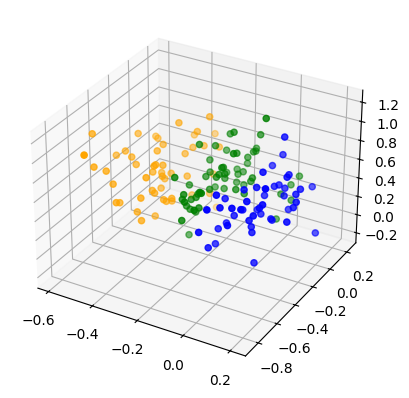

In [42]:
classification_chemicals=pd.DataFrame({"Name":table_Cardio.iloc[::2].values.tolist(), "Label":labels_rbf})
classification_chemicals.to_csv("cluster_cardiovascular_nn.csv")
colours = {}
colours[0] = 'blue'
colours[1] = 'orange'
colours[2] = 'green'
# Building the colour vector for each data point
cvec = [colours[label] for label in labels_rbf]
 
# Plotting the clustered scatter plot
fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
ax.scatter(x_coord, y_coord, z_coord, c=cvec)
#ax.legend((colours[0], colours[1], colours[2], colours[3], colours[4], colours[5], colours[6], colours[7]), ('Label 0', 'Label 1', 'Label 2', 'Label 3', 'Label 4', 'Label 5', 'Label 6', 'Label 7'))
plt.show()